In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Configurando o dispositivo (GPU se disponível)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cpu


In [4]:
# Definindo hiperparâmetros
latent_dim = 100
image_size = 28
batch_size = 32
num_epochs = 20
lr = 0.0002
beta1 = 0.5

# Carregando o dataset PathMNIST
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# Definindo as transformações
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

DataClass = getattr(medmnist, info['python_class'])
display(DataClass)

medmnist.dataset.PathMNIST

In [5]:
# Preparando os dados de treino
train_dataset = DataClass(split='train', transform=transform, download=download)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 206M/206M [00:26<00:00, 7.86MB/s] 


In [6]:

# Definindo o Gerador
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Camada de entrada
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            
            # Camadas intermediárias
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            
            # Camada de saída
            nn.Linear(1024, image_size * image_size * n_channels),
            nn.Tanh()
        )

    def forward(self, x):
        img = self.main(x)
        img = img.view(-1, n_channels, image_size, image_size)
        return img


In [7]:

# Definindo o Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Camada de entrada
            nn.Linear(image_size * image_size * n_channels, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Camadas intermediárias
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Camada de saída
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, image_size * image_size * n_channels)
        return self.main(x)

In [8]:
# Inicializando os modelos
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Definindo as funções de perda e otimizadores
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
# Função para salvar imagens geradas
def save_generated_images(epoch, generator, fixed_noise):
    with torch.no_grad():
        fake_images = generator(fixed_noise).cpu()
        plt.figure(figsize=(10, 10))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_images[i][0], cmap='gray')
            plt.axis('off')
        plt.savefig(f'fake_images_epoch_{epoch}.png')
        plt.close()

In [10]:
# Gerando ruído fixo para visualização
fixed_noise = torch.randn(16, latent_dim).to(device)
display(fixed_noise)

tensor([[ 0.2172,  0.1918, -1.3465,  ..., -0.4307, -0.4913,  0.4790],
        [-0.8995, -0.0560, -2.0014,  ...,  1.1169,  0.8679, -0.9819],
        [-0.6868, -0.3542, -0.0173,  ...,  1.8782, -0.4141, -0.8214],
        ...,
        [ 0.1527,  1.2872,  0.4429,  ...,  1.4363, -1.0335,  1.5079],
        [-1.1808,  0.2156,  0.2944,  ...,  0.4965,  2.1354,  2.0545],
        [ 0.1411, -0.1211, -0.4483,  ..., -0.4908,  0.3568, -0.0707]])

In [11]:
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Labels para dados reais e falsos
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # Treinar o Discriminador
        discriminator.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        # Treinar o Gerador
        generator.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')
    
    # Salvar imagens a cada 05 épocas
    if (epoch + 1) % 5 == 0:
        save_generated_images(epoch + 1, generator, fixed_noise)

Epoch [0/20], Step [100/2813], d_loss: 0.7166, g_loss: 0.7965
Epoch [0/20], Step [200/2813], d_loss: 1.2152, g_loss: 0.9672
Epoch [0/20], Step [300/2813], d_loss: 1.3022, g_loss: 0.7433
Epoch [0/20], Step [400/2813], d_loss: 1.4552, g_loss: 0.7951
Epoch [0/20], Step [500/2813], d_loss: 1.4034, g_loss: 0.6721
Epoch [0/20], Step [600/2813], d_loss: 1.3935, g_loss: 0.7091
Epoch [0/20], Step [700/2813], d_loss: 1.3597, g_loss: 0.6759
Epoch [0/20], Step [800/2813], d_loss: 1.3512, g_loss: 0.7779
Epoch [0/20], Step [900/2813], d_loss: 1.3722, g_loss: 0.7687
Epoch [0/20], Step [1000/2813], d_loss: 1.4473, g_loss: 0.6577
Epoch [0/20], Step [1100/2813], d_loss: 1.2974, g_loss: 0.8713
Epoch [0/20], Step [1200/2813], d_loss: 1.4091, g_loss: 0.7148
Epoch [0/20], Step [1300/2813], d_loss: 1.3328, g_loss: 0.6939
Epoch [0/20], Step [1400/2813], d_loss: 1.3535, g_loss: 0.7013
Epoch [0/20], Step [1500/2813], d_loss: 1.4459, g_loss: 0.7726
Epoch [0/20], Step [1600/2813], d_loss: 1.2862, g_loss: 0.6912
E

In [12]:
# Salvar os modelos
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth') 

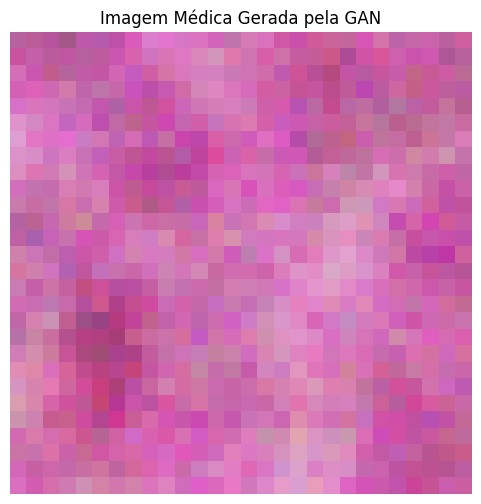

In [13]:
# Após treinar o modelo
noise = torch.randn(1, latent_dim).to(device)
fake_image = generator(noise)

# Preparar a imagem para visualização
fake_image = fake_image.cpu().detach()  # Move para CPU e remove do grafo computacional
fake_image = fake_image.numpy()  # Converte para numpy array
fake_image = fake_image.squeeze()  # Remove dimensões extras
fake_image = np.transpose(fake_image, (1, 2, 0))  # Muda a ordem das dimensões para (altura, largura, canais)
fake_image = (fake_image + 1) / 2.0  # Converte de [-1,1] para [0,1]

# Plotar a imagem
plt.figure(figsize=(6, 6))
plt.imshow(fake_image, cmap='gray')
plt.axis('off')
plt.title('Imagem Médica Gerada pela GAN')
plt.show()

In [14]:
# Gerar múltiplas imagens para aumentar dataset
num_synthetic = 1000
synthetic_images = []

for i in range(num_synthetic):
    noise = torch.randn(1, latent_dim)
    fake = generator(noise)
    synthetic_images.append(fake)

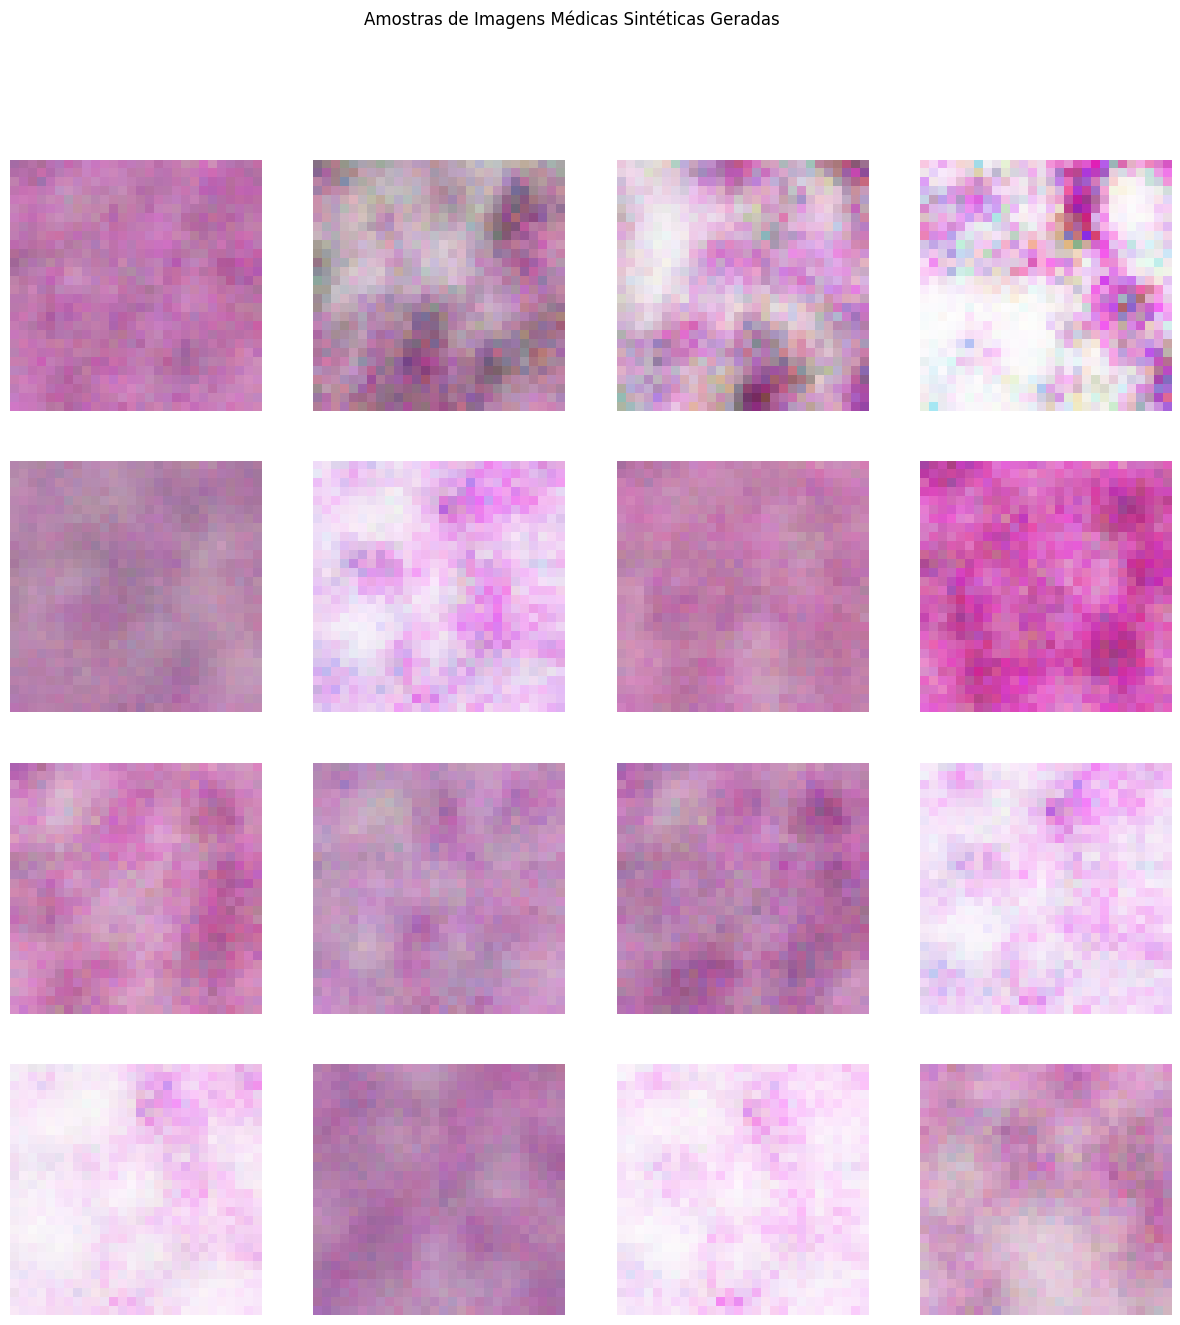

In [15]:
# Converter as imagens sintéticas para o formato adequado
synthetic_images = torch.cat(synthetic_images, dim=0)
synthetic_images = synthetic_images.cpu().detach().numpy()

# Salvar as imagens sintéticas
np.save('synthetic_images.npy', synthetic_images)

# Visualizar algumas imagens geradas
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = synthetic_images[i].squeeze()
    img = np.transpose(img, (1, 2, 0))
    img = (img + 1) / 2.0
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle('Amostras de Imagens Médicas Sintéticas Geradas')
plt.show()

In [ ]:

# Opcional: Salvar as imagens como arquivos individuais
import os
os.makedirs('synthetic_images', exist_ok=True)
for i in range(len(synthetic_images)):
    img = synthetic_images[i].squeeze()
    img = np.transpose(img, (1, 2, 0))
    img = (img + 1) / 2.0
    plt.imsave(f'synthetic_images/synthetic_{i}.png', img, cmap='gray')
